In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1.Load data

In [2]:
df_channel = pd.read_csv('orders_channels.csv')
df_country = pd.read_csv('orders_country.csv')
df_tickets = pd.read_csv('orders_tickets.csv')

## 2. Exploratory Data Analysis (EDA) and Data Preprocessing

In [3]:
df_channel.head()

,id,date,channel_id
0,10173,2017-06-12,39.0
1,95062,2017-09-11,35.0
2,171081,2017-07-05,39.0
3,122867,2017-08-18,39.0
4,107186,2017-11-23,NaN


In [4]:
df_channel.shape

(2054059, 3)

In [5]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054059 entries, 0 to 2054058
Data columns (total 3 columns):
id            int64
date          object
channel_id    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 47.0+ MB


In [6]:
df_channel['date'].isnull().sum()

0

In [7]:
df_channel['channel_id'].isnull().sum()

295625

In [8]:
df_channel['channel_id'].unique()

array([39., 35., nan, 28., 37., 40., 31., 49., 26., 29.,  2.,  1., 33.,
       17., 30., 25., 23., 38., 43., 36.,  5., 42., 41., 24.,  4., 27.,
       32., 47.,  8., 13.])

In [9]:
len(df_channel['channel_id'].unique())

30

fill channel_id nan with -1

In [10]:
df_channel['channel_id'].fillna(-1, inplace=True)

In [11]:
df_channel['channel_id'].unique()

array([39., 35., -1., 28., 37., 40., 31., 49., 26., 29.,  2.,  1., 33.,
       17., 30., 25., 23., 38., 43., 36.,  5., 42., 41., 24.,  4., 27.,
       32., 47.,  8., 13.])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AD82470>]],
      dtype=object)

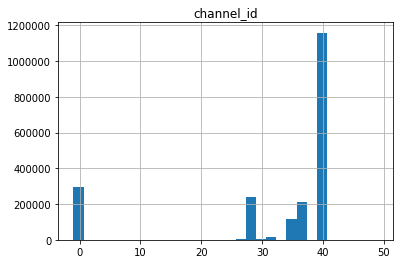

In [12]:
df_channel.hist(column='channel_id', bins=len(df_channel['channel_id'].unique()))

In [13]:
df_channel['date'] = pd.to_datetime(df_channel['date'])

In [14]:
df_country.head()

,id,country_1,country_2
0,10503,24.0,NaN
1,79360,24.0,0
2,81388,24.0,15
3,82828,24.0,9
4,38756,23.0,NaN


In [15]:
df_country.shape

(1917668, 3)

In [16]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917668 entries, 0 to 1917667
Data columns (total 3 columns):
id           int64
country_1    float64
country_2    object
dtypes: float64(1), int64(1), object(1)
memory usage: 43.9+ MB


In [17]:
df_country.describe()

,id,country_1
count,1.917668e+06,1.899837e+06
mean,9.850860e+05,1.896349e+01
std,5.687706e+05,7.798312e+00
min,1.000000e+00,4.000000e+00
25%,4.926018e+05,1.100000e+01
50%,9.849825e+05,2.400000e+01
75%,1.477636e+06,2.400000e+01
max,1.970544e+06,3.200000e+01


In [18]:
df_country['country_1'].isnull().sum()

17831

In [19]:
df_country['country_1'].unique()

array([24., 23., 19., 11., 12.,  9.,  4., 29., 14.,  5., 20., 26., 27.,
        8., 21.,  7., 32., nan, 28., 17., 15., 31., 16., 22.])

In [20]:
df_country['country_2'].isnull().sum()

748932

In [21]:
df_country['country_2'].unique()

array([nan, '0', '15', '9', '13', '4', '2', '6', '17', '8', '14', '20',
       '16', '12', '3', '19', '18', '11', 'xx', '1', '7'], dtype=object)

replace country nan with -1
replace country xx with -2

In [22]:
df_country['country_1'].fillna(-1, inplace=True)
df_country['country_2'].fillna(-1, inplace=True)
def f(x):
    if x=='xx':
        return '-2'
    return x
df_country['country_2'] = df_country['country_2'].apply(f)

In [23]:
df_country['country_1'].unique()

array([24., 23., 19., 11., 12.,  9.,  4., 29., 14.,  5., 20., 26., 27.,
        8., 21.,  7., 32., -1., 28., 17., 15., 31., 16., 22.])

In [24]:
df_country['country_2'].unique()

array([-1, '0', '15', '9', '13', '4', '2', '6', '17', '8', '14', '20',
       '16', '12', '3', '19', '18', '11', '-2', '1', '7'], dtype=object)

convert string to integer for country_2

In [25]:
df_country['country_2'] = pd.to_numeric(df_country['country_2'])
df_country['country_2'].unique()

array([-1,  0, 15,  9, 13,  4,  2,  6, 17,  8, 14, 20, 16, 12,  3, 19, 18,
       11, -2,  1,  7], dtype=int64)

convert float into integer for country_1

In [26]:
df_country['country_1'] = df_country['country_1'].astype(int)
df_country['country_2'].unique()

array([-1,  0, 15,  9, 13,  4,  2,  6, 17,  8, 14, 20, 16, 12,  3, 19, 18,
       11, -2,  1,  7], dtype=int64)

In [153]:
#le = LabelEncoder()
#le.fit(df_country['country_2'].tolist())
#df_country['country_2'] = le.transform(df_country['country_2'].tolist())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000068D1048>]],
      dtype=object)

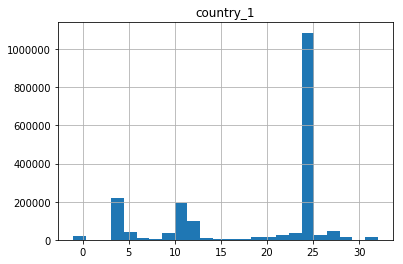

In [27]:
df_country.hist(column='country_1', bins=len(df_country['country_1'].unique()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000069766A0>]],
      dtype=object)

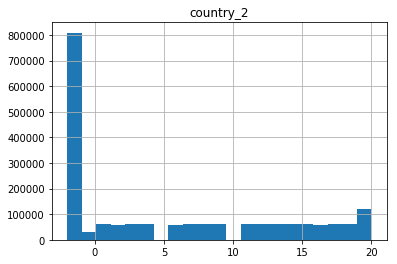

In [28]:
df_country.hist(column='country_2', bins=len(df_country['country_2'].unique()))

In [29]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917668 entries, 0 to 1917667
Data columns (total 3 columns):
id           int64
country_1    int32
country_2    int64
dtypes: int32(1), int64(2)
memory usage: 36.6 MB


In [30]:
df_country.head()

,id,country_1,country_2
0,10503,24,-1
1,79360,24,0
2,81388,24,15
3,82828,24,9
4,38756,23,-1


In [31]:
df_tickets.head()

,id,n_tickets,type
0,1586391,2,pax
1,438232,2,pax
2,270896,1,pax
3,1181593,2,pax
4,964842,1,pax


In [32]:
df_tickets.shape

(1999716, 3)

In [33]:
df_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999716 entries, 0 to 1999715
Data columns (total 3 columns):
id           int64
n_tickets    int64
type         object
dtypes: int64(2), object(1)
memory usage: 45.8+ MB


In [34]:
df_tickets['type'].unique()

array(['pax', 'other'], dtype=object)

In [35]:
df_tickets['n_tickets'].unique()

array([ 2,  1,  8,  4,  6,  5,  3, 12, 10,  7, 14, 20, 60,  9, 13, 11, 22,
       28, 15, 31, 40, 18, 24, 32, 26, 19, 16, 54, 44, 21, 23, 30, 56, 81,
       38, 52, 25, 17, 29, 34, 39, 49, 80, 66, 36, 42, 64, 27, 48, 46, 50,
       35, 41, 76, 70, 57, 58, 43, 45, 33, 68, 74, 67, 65, 47, 84, 37],
      dtype=int64)

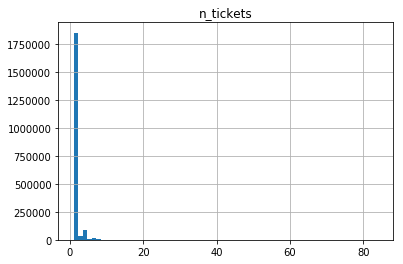

In [36]:
df_tickets.hist(column='n_tickets', bins=len(df_tickets['n_tickets'].unique()))
plt.show()

In [37]:
print(df_tickets['n_tickets'].min())
print(df_tickets['n_tickets'].max())
print(df_tickets['n_tickets'].mean())

1
84
1.4876737496724535


## 3. Data Preparation

In [38]:
df_merged = pd.merge(df_channel, df_tickets, how='left', on=['id'])

In [39]:
df_merged.head()

,id,date,channel_id,n_tickets,type
0,10173,2017-06-12,39.0,2,pax
1,95062,2017-09-11,35.0,1,pax
2,171081,2017-07-05,39.0,1,pax
3,122867,2017-08-18,39.0,1,other
4,107186,2017-11-23,-1.0,2,pax


In [40]:
df_merged = pd.merge(df_merged, df_country, how='left', on=['id'])

In [41]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2
0,10173,2017-06-12,39.0,2,pax,24.0,-1.0
1,95062,2017-09-11,35.0,1,pax,12.0,-1.0
2,171081,2017-07-05,39.0,1,pax,4.0,11.0
3,122867,2017-08-18,39.0,1,other,24.0,17.0
4,107186,2017-11-23,-1.0,2,pax,12.0,20.0


In [42]:
df_merged['country_1'].unique()

array([24., 12.,  4., 11., 26., 27., 16.,  9.,  5., 29., nan,  7., 15.,
       23., 31., 19., -1., 20., 21., 32., 14.,  8., 28., 17., 22.])

In [43]:
df_merged['country_1'].fillna(-1, inplace=True)

In [44]:
df_merged['country_1'].unique()

array([24., 12.,  4., 11., 26., 27., 16.,  9.,  5., 29., -1.,  7., 15.,
       23., 31., 19., 20., 21., 32., 14.,  8., 28., 17., 22.])

In [45]:
df_merged['country_1'] = df_merged['country_1'].astype(int)
df_merged['country_1'].unique()

array([24, 12,  4, 11, 26, 27, 16,  9,  5, 29, -1,  7, 15, 23, 31, 19, 20,
       21, 32, 14,  8, 28, 17, 22], dtype=int64)

In [46]:
df_merged['country_2'].unique()

array([-1., 11., 17., 20.,  4., 14., 12., -2., 13.,  7.,  8., 16.,  1.,
       15., 19., nan,  3., 18.,  9.,  2.,  6.,  0.])

In [47]:
df_merged['country_2'].fillna(-1, inplace=True)

In [48]:
df_merged['country_2'] = df_merged['country_2'].astype(int)
df_merged['country_2'].unique()

array([-1, 11, 17, 20,  4, 14, 12, -2, 13,  7,  8, 16,  1, 15, 19,  3, 18,
        9,  2,  6,  0], dtype=int64)

In [49]:
df_merged['channel_id'].unique()

array([39., 35., -1., 28., 37., 40., 31., 49., 26., 29.,  2.,  1., 33.,
       17., 30., 25., 23., 38., 43., 36.,  5., 42., 41., 24.,  4., 27.,
       32., 47.,  8., 13.])

In [50]:
df_merged['channel_id'] = df_merged['channel_id'].astype(int)

In [51]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

In [52]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084458 entries, 0 to 2084457
Data columns (total 7 columns):
id            int64
date          datetime64[ns]
channel_id    int32
n_tickets     int64
type          object
country_1     int32
country_2     int32
dtypes: datetime64[ns](1), int32(3), int64(2), object(1)
memory usage: 103.4+ MB


In [53]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2
0,10173,2017-06-12,39,2,pax,24,-1
1,95062,2017-09-11,35,1,pax,12,-1
2,171081,2017-07-05,39,1,pax,4,11
3,122867,2017-08-18,39,1,other,24,17
4,107186,2017-11-23,-1,2,pax,12,20


In [54]:
df_merged['n_tickets'].unique()

array([ 2,  1,  8,  4, 10,  6,  3,  5,  7, 11,  9, 26, 16, 12, 29, 20, 81,
       14, 18, 22, 28, 67, 56, 36, 23, 60, 24, 19, 30, 44, 48, 13, 15, 17,
       57, 21, 27, 54, 25, 40, 46, 58, 32, 38, 35, 42, 34, 70, 31, 43, 41,
       50, 74, 65, 52, 39, 68, 84, 80, 76, 45, 47, 37, 49, 33, 64, 66],
      dtype=int64)

#### some orders are assigned to two countries, with country_1 being more important. if there is no value in "country_1", use "country_2"

In [55]:
df_merged['country'] = df_merged['country_1'].values

In [56]:
df_merged['country'] = df_merged['country'].apply(lambda x: df_merged['country_2'] if x==1 else x)

In [57]:
df_merged['country'].unique()

array([24, 12,  4, 11, 26, 27, 16,  9,  5, 29, -1,  7, 15, 23, 31, 19, 20,
       21, 32, 14,  8, 28, 17, 22], dtype=int64)

In [58]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country
0,10173,2017-06-12,39,2,pax,24,-1,24
1,95062,2017-09-11,35,1,pax,12,-1,12
2,171081,2017-07-05,39,1,pax,4,11,4
3,122867,2017-08-18,39,1,other,24,17,24
4,107186,2017-11-23,-1,2,pax,12,20,12


In [59]:
df_merged['country'].isnull().sum()

0

In [60]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country
0,10173,2017-06-12,39,2,pax,24,-1,24
1,95062,2017-09-11,35,1,pax,12,-1,12
2,171081,2017-07-05,39,1,pax,4,11,4
3,122867,2017-08-18,39,1,other,24,17,24
4,107186,2017-11-23,-1,2,pax,12,20,12


In [61]:
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['year'] = df_merged['date'].dt.year

In [62]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country,month,day,year
0,10173,2017-06-12,39,2,pax,24,-1,24,6,12,2017
1,95062,2017-09-11,35,1,pax,12,-1,12,9,11,2017
2,171081,2017-07-05,39,1,pax,4,11,4,7,5,2017
3,122867,2017-08-18,39,1,other,24,17,24,8,18,2017
4,107186,2017-11-23,-1,2,pax,12,20,12,11,23,2017


In [63]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084458 entries, 0 to 2084457
Data columns (total 11 columns):
id            int64
date          datetime64[ns]
channel_id    int32
n_tickets     int64
type          object
country_1     int32
country_2     int32
country       int64
month         int64
day           int64
year          int64
dtypes: datetime64[ns](1), int32(3), int64(6), object(1)
memory usage: 167.0+ MB


save the merged dataframe to a csv

In [64]:
df_merged.to_csv('df_merged.csv', index=False)

### Approach 1

For each group (channel, country) 
- Train a regression model on the features (year, month, day) and label (number of tickets).
- Generate a test sample. The date of the test sample is the last date of the train sample in the sample group plus 10 days.
- Predict the label (number of tickets) of the test sample with the trained model.


In [65]:
df_merged = pd.read_csv('df_merged.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])
#df_merged['country'] = pd.to_numeric(df_merged['country'])
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084458 entries, 0 to 2084457
Data columns (total 11 columns):
id            int64
date          datetime64[ns]
channel_id    int64
n_tickets     int64
type          object
country_1     int64
country_2     int64
country       int64
month         int64
day           int64
year          int64
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 174.9+ MB


In [66]:
df_merged['date'].min()

Timestamp('2017-01-01 00:00:00')

In [67]:
df_merged['date'].max()

Timestamp('2018-02-26 00:00:00')

In [68]:
df_merged_grouped = df_merged.groupby(['channel_id', 'country'])

In [78]:
#clf_name = 'Ridge'
clf_name = 'Lasso'
#clf_name = 'LinearRegression'


#prepare the output
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}

# for each group, train a regression model and predict the number of tickets in the 10 days after the end
for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    
    # features are month and day, label is the number of tickets
    x_train = group[['year', 'month', 'day']]
    y_train = group[['n_tickets']]
    print('----')
    print(y_train.max())
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)

    if clf_name == 'Ridge':
        model = Ridge()
    elif clf_name == 'LinearRegression':
        model = LinearRegression()
        
    model.fit(x_train_scaled, y_train)
    
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)
    x_test = np.array([date_test.year, date_test.month, date_test.day]).reshape(1,3)
    x_test_scaled = scaler.transform(x_test)
    y_test = model.predict(x_test_scaled)

    # use the trained linear regression model to predict the number of the tickets in the 10 days after the end of the group
    dict_test['date'].append(date_test)
    dict_test['country'].append(group.iloc[0]['country'])
    dict_test['channel_id'].append(group.iloc[0]['channel_id'])
    if round(y_test[0][0]) < 0:
        y_test[0][0] = 0
    print(round(y_test[0][0]))
    print('----')
    dict_test['n_tickets'].append(round(y_test[0][0]))


----
n_tickets    22
dtype: int64
1.0
----
----
n_tickets    48
dtype: int64
1.0
----
----
n_tickets    24
dtype: int64
1.0
----
----
n_tickets    15
dtype: int64
2.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    36
dtype: int64
1.0
----
----
n_tickets    42
dtype: int64
1.0
----
----
n_tickets    32
dtype: int64
1.0
----
----
n_tickets    10
dtype: int64
2.0
----
----
n_tickets    12
dtype: int64
1.0
----
----
n_tickets    16
dtype: int64
2.0
----
----
n_tickets    70
dtype: int64
2.0
----
----
n_tickets    20
dtype: int64
2.0
----
----
n_tickets    46
dtype: int64
2.0
----
----
n_tickets    16
dtype: int64
2.0
----
----
n_tickets    29
dtype: int64
1.0
----


C:\Users\Chen.Kai\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


----
n_tickets    80
dtype: int64
1.0
----
----
n_tickets    15
dtype: int64
2.0
----
----
n_tickets    48
dtype: int64
2.0
----
----
n_tickets    10
dtype: int64
1.0
----
----
n_tickets    32
dtype: int64
1.0
----
----
n_tickets    16
dtype: int64
1.0
----
----
n_tickets    9
dtype: int64
1.0
----
----
n_tickets    4
dtype: int64
1.0
----
----
n_tickets    6
dtype: int64
2.0
----
----
n_tickets    5
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
1.0
----
----
n_tickets    2
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
1.0
----
----
n_tickets    4
dtype: int64
2.0
----
----
n_tickets    4
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
1.0
----
----
n_tickets    2
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
1.0
----
----
n_tickets    2
dtype: int64
2.0
----
----
n_tickets    8
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
0.0
----
----
n_tickets    4
dtype: int64
2.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    4
dtype: i

2.0
----
----
n_tickets    17
dtype: int64
1.0
----
----
n_tickets    10
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    4
dtype: int64
1.0
----
----
n_tickets    6
dtype: int64
1.0
----
----
n_tickets    4
dtype: int64
2.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    6
dtype: int64
2.0
----
----
n_tickets    6
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    25
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    12
dtype: int64
2.0
----
----
n_tickets    2
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
2.0
----
----
n_tickets    8
dtype: int64
2.0
----
----
n_tickets    4
dtype: int64
1.0
----
----
n_tickets    2
dtype: int64
0.0
----
----
n_tickets    1
dtype: int64
1.0
----
----
n_tickets    2
dtype: int64
3.0
----
----
n_tickets    4
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
1.0
----
----
n_tickets    8
dtype: int64
2.0
----
----
n_tickets    2
d

In [79]:
df_test = pd.DataFrame(dict_test)

In [80]:
df_test

,date,country,channel_id,n_tickets
0,2018-03-08,-1,-1,1.0
1,2018-03-08,4,-1,1.0
2,2018-03-08,5,-1,1.0
3,2018-03-08,7,-1,2.0
4,2018-03-08,8,-1,1.0
5,2018-03-08,9,-1,1.0
6,2018-03-08,11,-1,1.0
7,2018-03-08,12,-1,1.0
8,2018-03-08,14,-1,2.0
9,2018-03-07,15,-1,1.0


In [81]:
set(df_test['n_tickets'].tolist())

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 26.0}

Based on the prediction results, it shows that with only year, month, and day it is not possible to estimate number of tickets correctly.

save prediction results to a csv

In [73]:
df_test.to_csv('pred_approach1_ridge.csv', index=False)

### Approach 2

For each group (channel, country) 
- Compute the average number of tickets and this number would be the number of tickets in the next 10 days

### Approach 2 (does not work)

- Train a regression model on all the data. The features are: date (year, month, day), channel, and country. The label is the number of tickets.
- For each group (channel, country), create a test sample as presented in Approach 1.
- Use the trained regression model to predict the number of tickets of all the test samples.

In [ ]:
df_merged = pd.read_csv('df_merged.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged.info()

In [ ]:
df_merged.columns

#### Prepare the training set

In [ ]:
cols_feature = ['channel_id', 'country', 'year', 'month', 'day']

In [ ]:
len(cols_feature)

In [ ]:
x_train = df_merged[cols_feature]

In [ ]:
x_train.shape

In [ ]:
y_train = df_merged[['n_tickets']]

In [ ]:
y_train.shape

#### Prepare the test set

In [ ]:
df_merged_grouped = df_merged.groupby(['channel_id', 'country'])

In [ ]:
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}
for col_feature in cols_feature:
    dict_test[col_feature] = []

In [ ]:
dict_test

In [ ]:
df_test = pd.DataFrame(dict_test)

In [ ]:
cols_feature

In [ ]:
for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    
    # get the last date of the group
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)

    # generate test sample
    dict_test['date'].append(date_test)
    dict_test['n_tickets'] = 0
    for col_feature in cols_feature:
        dict_test[col_feature].append(group.iloc[0][col_feature])   

In [ ]:
df_test = pd.DataFrame(dict_test)
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['year'] = df_test['date'].dt.year

In [ ]:
df_test.info()

In [ ]:
x_test = df_test[cols_feature]

In [ ]:
x_test.shape

#### Model training

xgboost

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.kaggle.com/mburakergenc/predictions-with-xgboost-and-linear-regression

One advantage of tree based model is that it works directly on the categorical features. No one-hot and feature scaling are needed.

In [ ]:
import xgboost as xgb

x_train_sub, x_val, y_train_sub, y_val = train_test_split(x_train, y_train, test_size = 0.1)

dtrain = xgb.DMatrix(x_train, label=y_train)
dsubtrain = xgb.DMatrix(x_train_sub, label=y_train_sub)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    #'eval_metric':'mae',
    'eval_metric':'rmse',
    'n_estimators': 200,
}

model = xgb.train(
    params,
    dsubtrain,
    num_boost_round = 100,
    evals = [(dval, "Test")],
    early_stopping_rounds = 5
)


#### Prediction

In [ ]:
predicted = model.predict(dtest)
df_test['n_tickets'] = list(predicted)
df_test['n_tickets'] = df_test['n_tickets'].astype(int)
df_test.head()

In [ ]:
df_test['n_tickets'].unique()

In [ ]:
df_test.hist(column='n_tickets', bins=len(df_test['n_tickets'].unique()))
plt.show()

In [ ]:
for col_to_drop in ['year', 'month', 'day']:
    if col_to_drop in df_test.columns:
        df_test.drop(col_to_drop, inplace=True, axis=1)

In [ ]:
df_test.head()

#### Saving prediction 

In [ ]:
df_test.to_csv('pred_approach2_xgboost.csv', index=False)

#### Hyperparameter tuning

In [ ]:
best_params = ()

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
    #'eval_metric':'mae',
    'eval_metric':'rmse',
}

cv_results = {}

# Define initial best params and RMSE
min_rmse = float("Inf")

best_params = None

gridsearch_params = [
    (max_depth, min_child_weight)
    #for max_depth in range(9,12)
    for max_depth in [2, 4, 6, 8]
    for min_child_weight in [5, 6, 8]
    #for min_child_weight in range(5,8)
]


for (max_depth, min_child_weight) in gridsearch_params:
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=200,
        seed=42,
        nfold=3,
        #metrics={'mae'},
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)
        print("update best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))
        
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

In [ ]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

model = xgb.train(
    params,
    dsubtrain,
    num_boost_round=100,
    evals=[(dval, "Test")],
    early_stopping_rounds=5
)

In [ ]:
predicted = model.predict(dtest)
df_test['n_tickets'] = list(predicted)
df_test['n_tickets'] = df_test['n_tickets'].astype(int)
df_test.head()

In [ ]:
df_test['n_tickets'].unique()

In [ ]:
df_test.hist(column='n_tickets', bins=len(df_test['n_tickets'].unique()))
plt.show()

In [ ]:
for col_to_drop in ['year', 'month', 'day']:
    if col_to_drop in df_test.columns:
        df_test.drop(columns=[col_to_drop], inplace=True)

In [ ]:
df_test.to_csv('pred_approach2_xgboost_max-depth-{}_min-child-weight-{}.csv'.format(params['max_depth'], params['min_child_weight']), index=False)

#### TODO: for other no-tree based model one-hot encoding on categorical features is needed

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [ ]:
cols_cat = ['channel_id', 'country']
for col_cat in cols_cat:
    one_hot = pd.get_dummies(df_merged[col_cat], prefix=col_cat)
    #df_merged = df_merged.drop(col_cat, axis = 1)
    df_merged = df_merged.join(one_hot)

In [ ]:
cols_feature = list(df_merged.columns) 
for col_remove in ['id', 'channel_id', 'country', 'date', 'n_tickets', 'type', 'country_1', 'country_2']:
    cols_feature.remove(col_remove)

#### TODO: Check cross validation scores for different regression model
https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression

In [ ]:
loo = cross_validation.LeaveOneOut(len(y_train))

In [ ]:
scores = cross_validation.cross_val_score(LinearRegression(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Lasso(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Ridge(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

#### TODO: Train a regression model with parameter tuning
https://stackoverflow.com/questions/49522928/cross-validation-in-linear-regression


In [ ]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('regr', Ridge())
])

param_grid = [
    {
        'regr': [Lasso(), Ridge()],
        'regr__alpha': np.logspace(-4, 1, 6),
    },
    {
        'regr': [SGDRegressor()],
        'regr__alpha': np.logspace(-5, 0, 6),
        'regr__max_iter': [500, 1000],
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=4, verbose=2)
grid.fit(x_train, y_train)



In [ ]:
predicted = grid.predict(x_test)
dict_test['n_tickets'] = y_test


In [ ]:
dict_test

In [ ]:
df_test.to_csv('pred_approach2_xgboost.csv', index=False)

#### TODO: Try other regression models
https://gogul09.github.io/software/sklearn-regression-models

## 3. Conclusion